In [2]:
# Dictionary mapping RefSeq IDs to chromosome names
refseq_to_chr = {
    "NC_007299.6": "chr1", "NC_007300.6": "chr2", "NC_007301.6": "chr3", "NC_007302.6": "chr4",
    "NC_007303.6": "chr5", "NC_007304.6": "chr6", "NC_007305.6": "chr7", "NC_007306.6": "chr8",
    "NC_007307.6": "chr9", "NC_007308.6": "chr10", "NC_007309.6": "chr11", "NC_007310.6": "chr12",
    "NC_007311.6": "chr13", "NC_007312.6": "chr14", "NC_007313.6": "chr15", "NC_007314.5": "chr16",
    "NC_007315.6": "chr17", "NC_007316.6": "chr18", "NC_007317.6": "chr19", "NC_007318.6": "chr20",
    "NC_007319.6": "chr21", "NC_007320.6": "chr22", "NC_007324.6": "chr23", "NC_007325.6": "chr24",
    "NC_007326.6": "chr25", "NC_007327.6": "chr26", "NC_007328.5": "chr27", "NC_007329.6": "chr28",
    "NC_007330.6": "chr29", "NC_007331.5": "chrX", "NC_016145.1": "chrY"
}

# Input and output file paths
input_fasta = "/data/pfenninggroup/machineLearningForComputationalBiology/regElEvoGrant/200MammalsFastas/GCF_000003205.7_Btau_5.0.1_genomic.fna"  # Replace with your FASTA file path
output_fasta = "/home/azstephe/regression_liver/data/splits/cowMouse/GCF_000003205.7_Btau_5.0.1_genomic_chromName.fna"  # Output file path

# Process the FASTA file
with open(input_fasta, 'r') as infile, open(output_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith(">"):  # If it's a header line
            refseq_id = line.strip().split()[0][1:]  # Extract the RefSeq ID (remove '>')
            chr_name = refseq_to_chr.get(refseq_id, refseq_id)  # Get chromosome name or keep original
            outfile.write(f">{chr_name}\n")  # Write converted header
        else:
            outfile.write(line)  # Write sequence lines unchanged

print(f"Conversion complete! Output written to {output_fasta}")


Conversion complete! Output written to /home/azstephe/regression_liver/data/splits/cowMouse/GCF_000003205.7_Btau_5.0.1_genomic_chromName.fna


In [24]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np


pred_df = pd.read_csv('../model_outputs/r0p9r0em/activations_cow_VAL.csv', header=None)
val1_df = pd.read_csv('../splits/val1/cow_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val2_df = pd.read_csv('../splits/val2/cow_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv('../splits/val3/cow_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)
val3_len = 2*len(val3_df)

doubled_val1_df = pd.concat([val1_df, val1_df]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_val3_df = pd.concat([val3_df, val3_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val1_df = pred_df.head(val1_len)
pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len]
pred_val3_df = pred_df.tail(val3_len)

# neg_df = pd.read_csv('../splits/negatives/nonMouse_liver_andRat_andCow_andPig_andMacaque_VAL_500bp.bed', header=None, delim_whitespace=True).iloc[:,4]
# neg_len = len(neg_df)
# doubled_ndf = pd.DataFrame(np.zeros((neg_len*2, 1)))
doubled_combined = pd.concat([doubled_val1_df, doubled_val2_df, doubled_val3_df])

def scatter(pred_df, true_df, group):
    x = true_df.squeeze()
    y = pred_df.squeeze() 
    
    plt.figure(figsize=(8, 6))
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.plot([0, 4], [0, 4], color='#015088', linestyle='--', label='y = x')
    plt.gcf().set_facecolor('#f3f0dfff')
    plt.gca().set_facecolor('#f3f0dfff')
    plt.scatter(x, y, alpha=0.2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Scatter Plot of {group} True vs Predicted Values')
    plt.grid(True)
    plt.show()

def plotscatter():
    # scatter(pred_val1_df, doubled_val1_df, 'val1')
    scatter(pred_val2_df, doubled_val2_df, 'val2')
    scatter(pred_val3_df, doubled_val3_df, 'val3')

def histogram(pred_df, name):
    plt.hist(pred_df, bins=50, color='#015088')
    plt.gcf().set_facecolor('#f3f0dfff')
    plt.gca().set_facecolor('#f3f0dfff')
    plt.xlabel(f'Predicted Values for {name}')
    plt.ylabel('Count')
    plt.title(f'Histogram of Predicted Values')
    plt.show()

def ploth():
    histogram(pred_val1_df, 'val1')
    histogram(pred_val2_df, 'val2')
    histogram(pred_val3_df, 'val3')
    
def correlations(pred_df, true_df, group):
    x = true_df.squeeze()
    y = pred_df.squeeze()
    
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient for {group}: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")
    
    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient for {group}: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

def correlate():
    print(f'val1 average prediction: {pred_val1_df.mean()}')
    correlations(pred_df, doubled_combined, 'all')
    correlations(pred_val2_df, doubled_val2_df, 'val2')
    correlations(pred_val3_df, doubled_val3_df, 'val3')
    # correlations(pred_df.tail(neg_len*2), doubled_ndf, 'negative')

def wilcoxon(neg, pos):
    stat, p_value = scipy.stats.ranksums(neg, pos)
    print("Wilcoxon Rank-Sum Test:")
    print(f"Test Statistic: {stat}")
    print(f"P-value: {p_value}")
    
    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the two distributions (reject null hypothesis).")
    else:
        print("There is no significant difference between the two distributions (fail to reject null hypothesis).")

    
def wilcox():
    wilcoxon(pred_val1_df, pred_val2_df)
    wilcoxon(pred_val1_df, pred_val3_df)



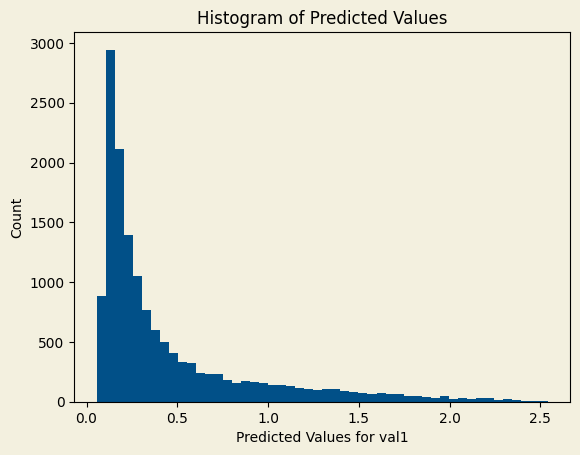

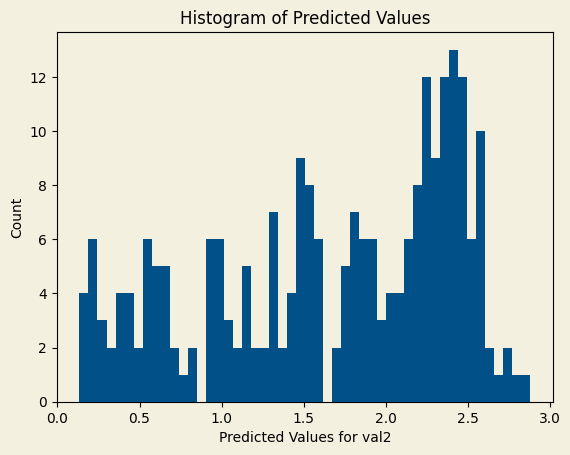

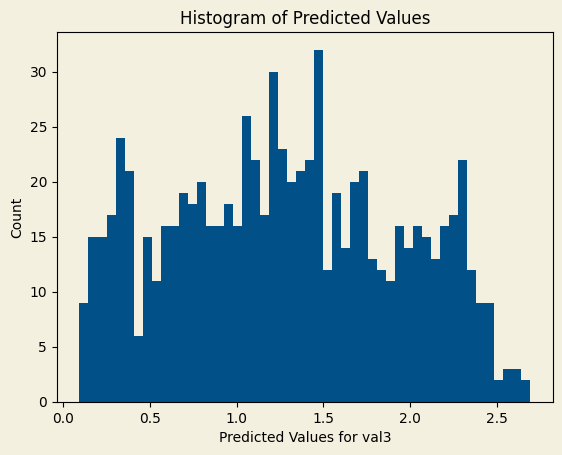

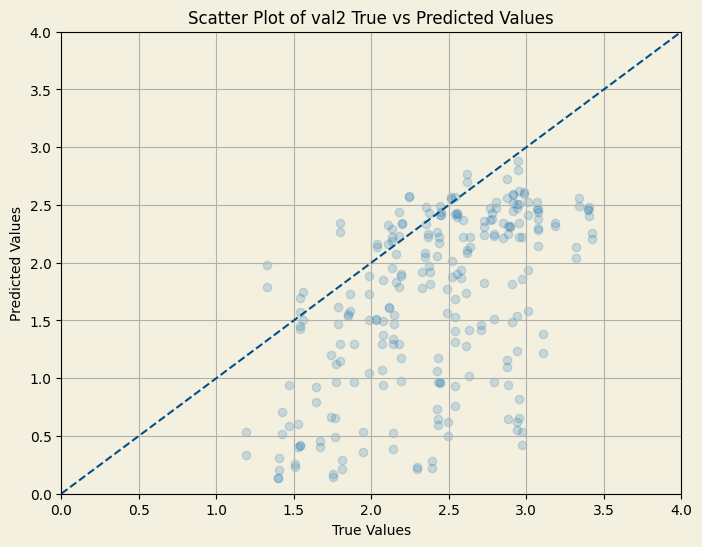

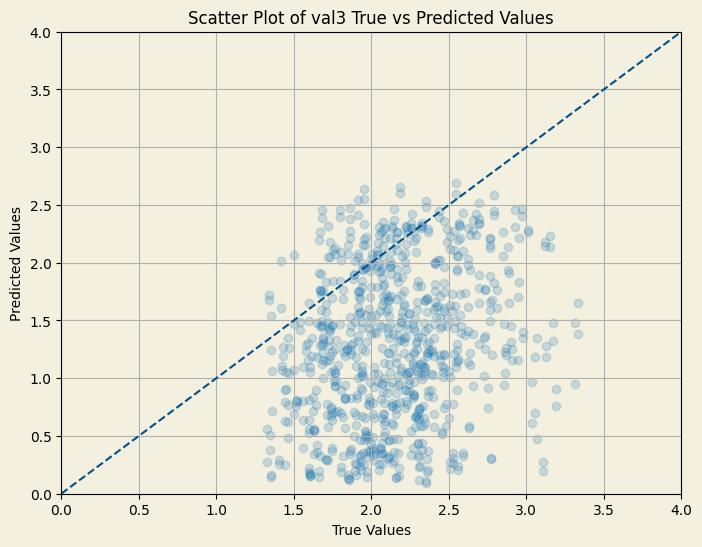

val1 average prediction: 0    0.453135
dtype: float64
Pearson correlation coefficient for all: 0.4436, p-value: 0
Spearman correlation coefficient for all: 0.3188, p-value: 0
Pearson correlation coefficient for val2: 0.5400, p-value: 1.442e-19
Spearman correlation coefficient for val2: 0.5395, p-value: 1.595e-19
Pearson correlation coefficient for val3: 0.2232, p-value: 2.111e-10
Spearman correlation coefficient for val3: 0.2178, p-value: 5.896e-10


In [26]:
ploth()
plotscatter()
correlate()

In [38]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np


pred_df = pd.read_csv('../model_outputs/1c8n0ubm/activations_pig_VAL.csv', header=None)
val1_df = pd.read_csv('../splits/val1/pig_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val2_df = pd.read_csv('../splits/val2/pig_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]
val3_df = pd.read_csv('../splits/val3/pig_liver_VAL.narrowPeak', header=None, delim_whitespace=True).iloc[:,4]

val1_len = 2*len(val1_df)
val2_len = 2*len(val2_df)
val3_len = 2*len(val3_df)

doubled_val1_df = pd.concat([val1_df, val1_df]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_val2_df = pd.concat([val2_df, val2_df]).sort_index(kind='mergesort').reset_index(drop=True)
doubled_val3_df = pd.concat([val3_df, val3_df]).sort_index(kind='mergesort').reset_index(drop=True)

pred_val1_df = pred_df.head(val1_len)
pred_val2_df = pred_df.iloc[val1_len:val1_len + val2_len]
pred_val3_df = pred_df.tail(val3_len)

doubled_combined = pd.concat([doubled_val1_df, doubled_val2_df, doubled_val3_df])

def scatter(pred_df, true_df, group):
    x = true_df.squeeze()
    y = pred_df.squeeze() 
    
    plt.figure(figsize=(8, 6))
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.plot([0, 4], [0, 4], color='#015088', linestyle='--', label='y = x')
    plt.gcf().set_facecolor('#f3f0dfff')
    plt.gca().set_facecolor('#f3f0dfff')
    plt.scatter(x, y, alpha=0.2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Scatter Plot of {group} True vs Predicted Values')
    plt.grid(True)
    plt.show()

def plotscatter():
    # scatter(pred_val1_df, doubled_val1_df, 'val1')
    scatter(pred_val2_df, doubled_val2_df, 'val2')
    # scatter(pred_val3_df, doubled_val3_df, 'val3')

def histogram(pred_df, name):
    plt.hist(pred_df, bins=50, color='#015088')
    plt.gcf().set_facecolor('#f3f0dfff')
    plt.gca().set_facecolor('#f3f0dfff')
    plt.xlabel(f'Predicted Values for {name}')
    plt.ylabel('Count')
    plt.title(f'Histogram of Predicted Values')
    plt.show()

def ploth():
    histogram(pred_val1_df, 'val1')
    # histogram(pred_val2_df, 'val2')
    # histogram(pred_val3_df, 'val3')
    
def correlations(pred_df, true_df, group):
    x = true_df.squeeze()
    y = pred_df.squeeze()
    
    pearson_corr, pearson_p_value = scipy.stats.pearsonr(x, y)
    print(f"Pearson correlation coefficient for {group}: {pearson_corr:.4f}, p-value: {pearson_p_value:.4g}")
    
    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    print(f"Spearman correlation coefficient for {group}: {spearman_corr:.4f}, p-value: {spearman_p_value:.4g}")

def correlate():
    print(f'val1 average prediction: {pred_val1_df.mean()}')
    correlations(pred_df, doubled_combined, 'all')
    correlations(pred_val2_df, doubled_val2_df, 'val2')
    correlations(pred_val3_df, doubled_val3_df, 'val3')
    # correlations(pred_df.tail(neg_len*2), doubled_ndf, 'negative')

def wilcoxon(neg, pos):
    stat, p_value = scipy.stats.ranksums(neg, pos)
    print("Wilcoxon Rank-Sum Test:")
    print(f"Test Statistic: {stat}")
    print(f"P-value: {p_value}")
    
    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference between the two distributions (reject null hypothesis).")
    else:
        print("There is no significant difference between the two distributions (fail to reject null hypothesis).")

    
def wilcox():
    wilcoxon(pred_val1_df, pred_val2_df)
    wilcoxon(pred_val1_df, pred_val3_df)



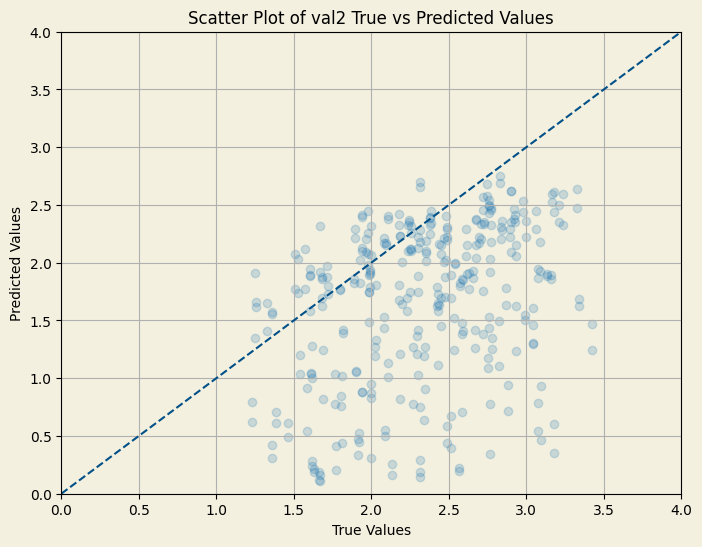

In [39]:
# ploth()
plotscatter()
# correlate()